In [1]:
from pathlib import Path

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


ROOT_DIR = Path(os.getcwd()).parent

In [2]:
df = pd.read_parquet(
    os.path.join(ROOT_DIR, "data/datasets/train_different_windows.parquet")
)

In [3]:
num_cols = [col for col in df.columns if "mean" in col or "imbalance" in col]
intervals = ["1d", "7d", "14d", "30d"]


df_individual = pd.DataFrame()

for interval in intervals:
    df_individual[f"log_return_mean_{interval}"] = (
        df[f"log_return_mean_{interval}"] / df["log_return_std_30d"]
    )

for feature in ["qty_abs", "num_trades"]:
    for interval in intervals:
        df_individual[f"{feature}_mean_{interval}"] = (
            df[f"{feature}_mean_{interval}"] / df[f"{feature}_mean_30d"]
        )

imbalance_cols = [
    f"imbalance_ratio_{interval}" for interval in intervals
]

df_individual[imbalance_cols] = df[imbalance_cols]
df_individual["ticker"] = df["ticker"]
df_individual["pumped_ticker"] = df["pumped_ticker"]
df_individual["pump_time"] = df["pump_time"]

df_individual.head(5)

,log_return_mean_1d,log_return_mean_7d,log_return_mean_14d,log_return_mean_30d,qty_abs_mean_1d,qty_abs_mean_7d,qty_abs_mean_14d,qty_abs_mean_30d,num_trades_mean_1d,num_trades_mean_7d,num_trades_mean_14d,num_trades_mean_30d,imbalance_ratio_1d,imbalance_ratio_7d,imbalance_ratio_14d,imbalance_ratio_30d,ticker,pumped_ticker,pump_time
index,,,,,,,,,,,,,,,,,,,
0,-0.144663,-0.085569,-0.020079,-0.034863,0.668136,0.760297,0.836233,1.0,0.816859,0.686170,0.800160,1.0,0.338295,-0.076248,-0.047910,-0.053628,EVXBTC,STORJBTC,2018-12-08 18:45:00+00:00
0,0.065583,-0.072877,-0.044778,-0.051537,1.087880,1.582355,1.269932,1.0,0.672847,0.984600,0.927494,1.0,-0.053473,-0.161770,-0.159361,-0.145932,SKYBTC,STORJBTC,2018-12-08 18:45:00+00:00
0,0.032189,-0.073359,-0.013763,-0.046514,1.028437,1.084514,1.311372,1.0,0.558401,0.711439,0.976799,1.0,-0.102085,-0.013093,-0.010431,-0.058007,STORMBTC,STORJBTC,2018-12-08 18:45:00+00:00
0,0.065009,-0.026428,0.013351,-0.025978,0.473250,1.912933,1.554276,1.0,0.638020,1.718748,1.368415,1.0,-0.063176,-0.103105,-0.112501,-0.123222,VIBEBTC,STORJBTC,2018-12-08 18:45:00+00:00
0,0.071932,-0.046724,0.003375,-0.035631,0.557475,0.798271,1.142745,1.0,0.719940,0.804368,1.008668,1.0,-0.140527,-0.097883,-0.077349,-0.089628,WINGSBTC,STORJBTC,2018-12-08 18:45:00+00:00


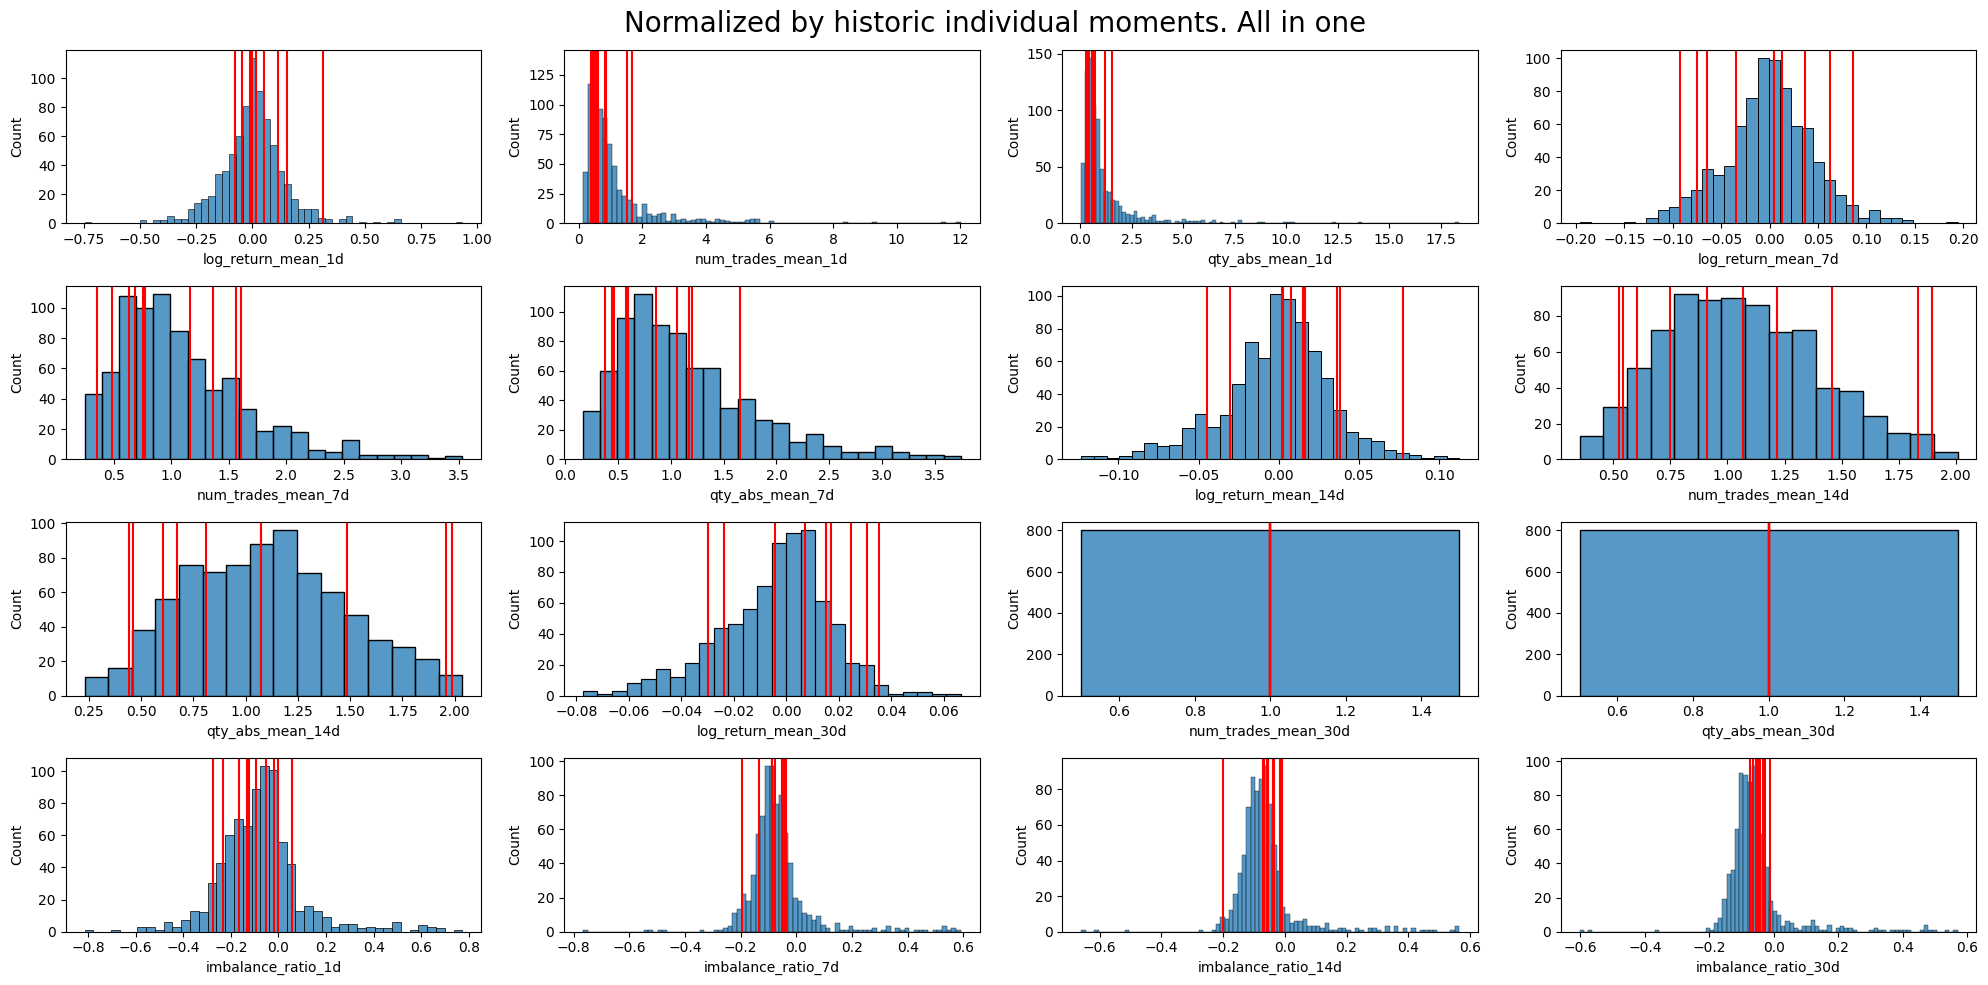

In [4]:
fig, axs = plt.subplots(4, 4, figsize=(20, 10))
axs = [ax for ax_list in axs for ax in ax_list]

for col, ax in zip(num_cols, axs):
    sns.histplot(ax=ax, data=df_individual[col])
    for (ticker, pump_time), _ in df_individual.groupby(["pumped_ticker", "pump_time"]):
        ax.axvline(
            x=df_individual[
                (df_individual["ticker"] == ticker)
                & (df_individual["pump_time"] == pump_time)
            ][col].iloc[0],
            color="red",
        )

plt.suptitle("Normalized by historic individual moments. All in one", size=20)
plt.tight_layout()

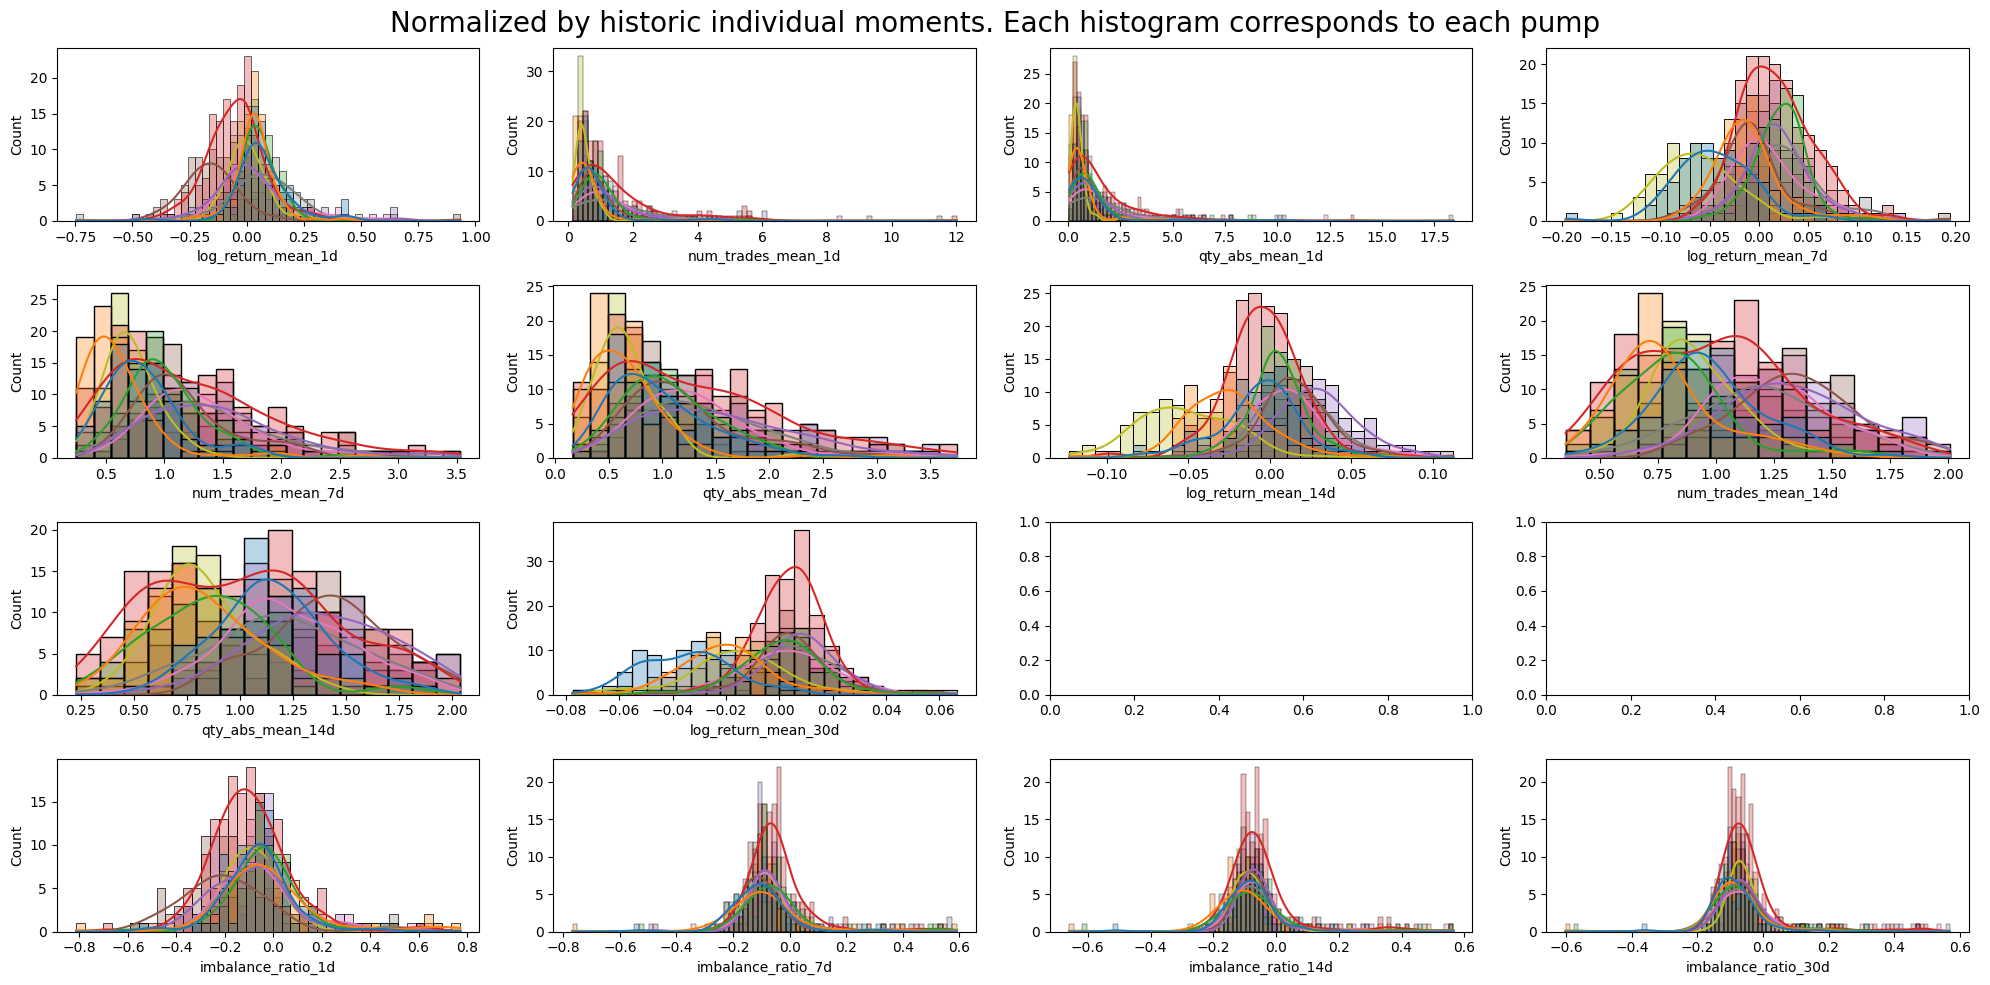

In [5]:
fig, axs = plt.subplots(4, 4, figsize=(20, 10))
axs = [ax for ax_list in axs for ax in ax_list]

for col, ax in zip(num_cols, axs):
    if col in ["num_trades_mean_30d", "qty_abs_mean_30d"]:
        continue
    sns.histplot(data=df_individual, x=col, hue="pumped_ticker", kde=True, alpha=.3, ax=ax, legend=False)

plt.suptitle("Normalized by historic individual moments. Each histogram corresponds to each pump", size=20)
plt.tight_layout()
plt.show()

In [6]:
df_means = df.groupby(["pumped_ticker", "pump_time"])[num_cols].mean()
df_means = df_means.reset_index()

In [7]:
df_crosssection = df.merge(
    df_means, on=["pump_time", "pumped_ticker"], how="left", suffixes=["", "_mean_crosssection"]
)

In [8]:
for col in num_cols:
    df_crosssection[col] -= df_crosssection[f"{col}_mean_crosssection"]

df_crosssection = df_crosssection.drop(
    columns=[col for col in df_crosssection.columns if col.endswith("_mean_crosssection")]
)

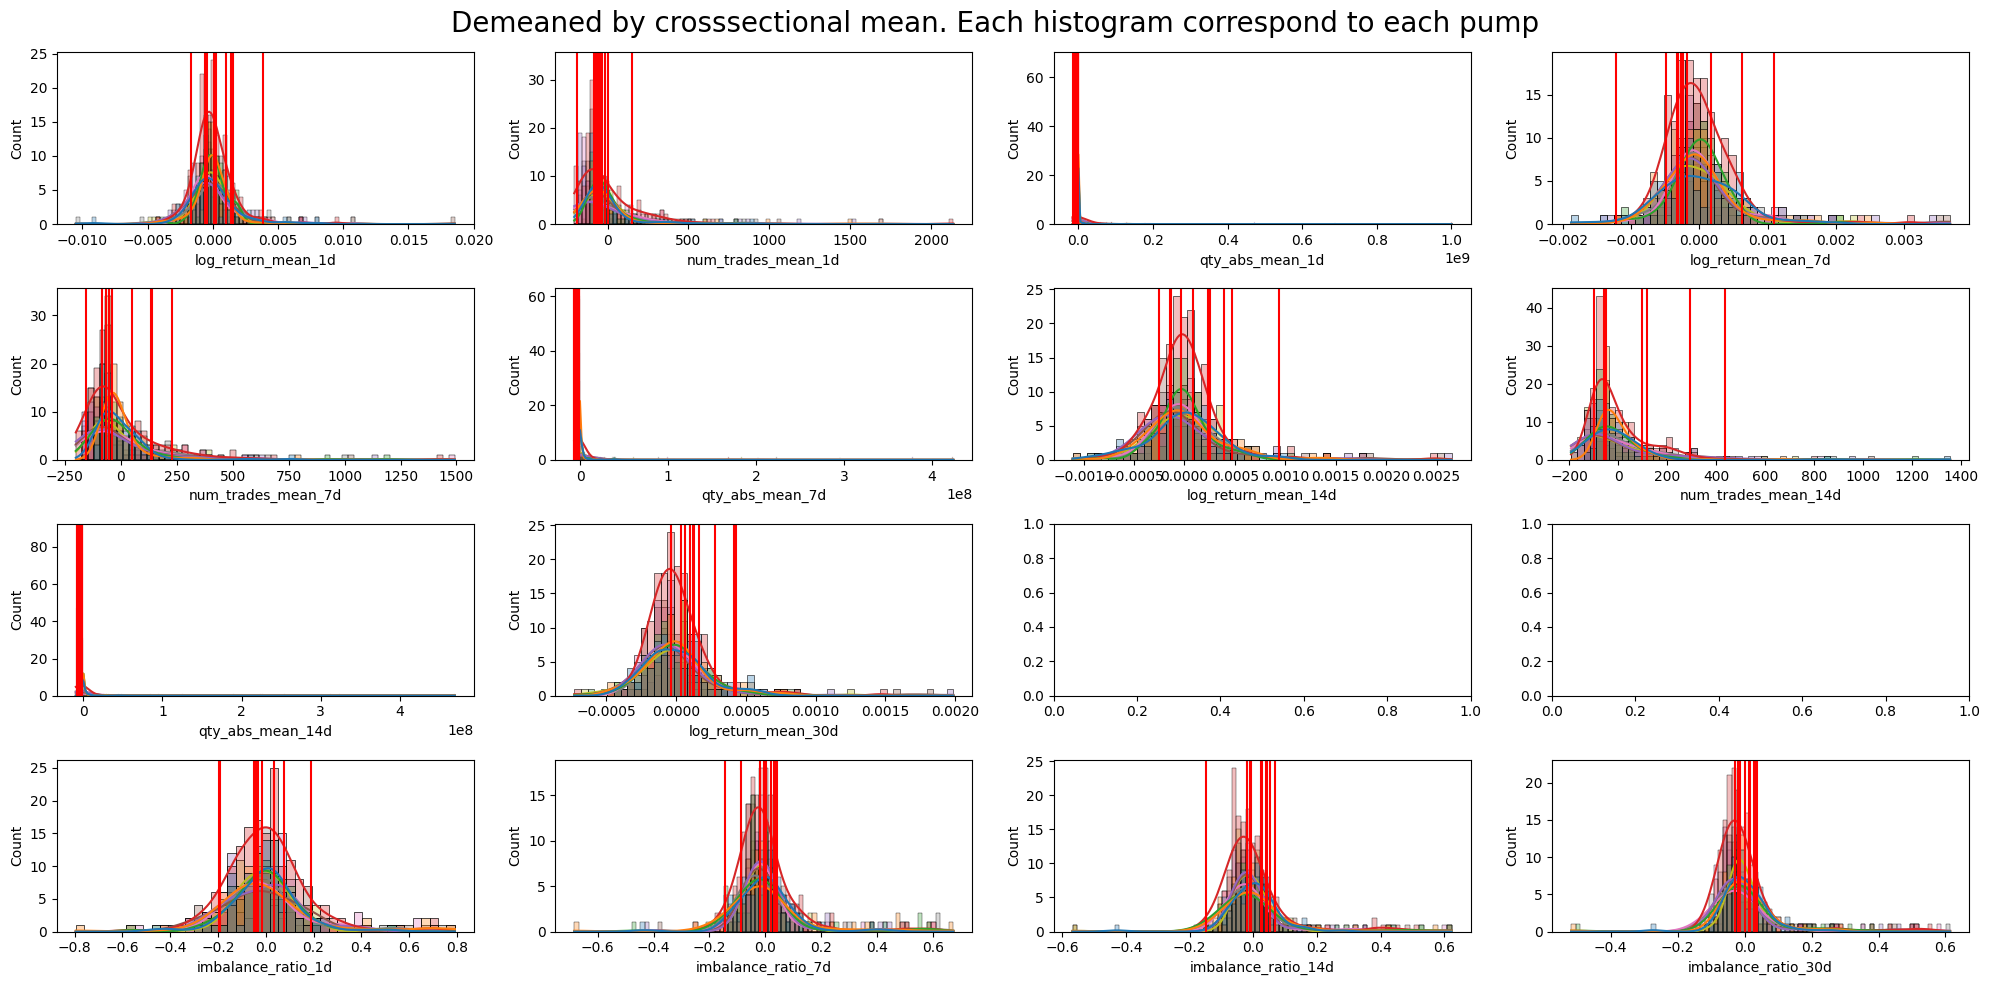

In [9]:
fig, axs = plt.subplots(4, 4, figsize=(20, 10))
axs = [ax for ax_list in axs for ax in ax_list]

for col, ax in zip(num_cols, axs):
    if col in ["num_trades_mean_30d", "qty_abs_mean_30d"]:
        continue
    sns.histplot(data=df_crosssection, x=col, hue="pumped_ticker", kde=True, alpha=.3, ax=ax, legend=False)

    for (ticker, pump_time), _ in df_crosssection.groupby(["pumped_ticker", "pump_time"]):
        ax.axvline(
            x=df_crosssection[
                (df_crosssection["ticker"] == ticker)
                & (df_crosssection["pump_time"] == pump_time)
            ][col].iloc[0],
            color="red",
        )
    

plt.suptitle("Demeaned by crosssectional mean. Each histogram correspond to each pump", size=20)
plt.tight_layout()
plt.show()

<h4>CMC volume</h4>

In [93]:
df_cmc = pd.read_parquet(
    os.path.join(ROOT_DIR, "data/cmc/cmc_snapshots.parquet")
)

df_cmc["snapshot"] = pd.to_datetime(df_cmc["snapshot"], format="%Y%m%d")
df_cmc.head()

,name,symbol,slug,cmc_rank,mcap_usdt,mcap_btc,snapshot,trading_volume_usdt,trading_volume_btc
0,Bitcoin,BTC,bitcoin,1,1.605041e+10,1.665571e+07,2017-01-01,1.477752e+08,153348.114011
1,Ethereum,ETH,ethereum,2,7.150493e+08,7.420155e+05,2017-01-01,1.473169e+07,15287.252215
2,XRP,XRP,xrp,3,2.314087e+08,2.401357e+05,2017-01-01,4.189777e+05,434.778345
3,Litecoin,LTC,litecoin,4,2.217185e+08,2.300800e+05,2017-01-01,1.133750e+07,11765.061474
4,Monero,XMR,monero,5,1.909836e+08,1.981860e+05,2017-01-01,3.923545e+06,4071.511286


In [106]:
from datetime import timedelta
from typing import *


def load_data(ticker: str, start: pd.Timestamp, end: pd.Timestamp) -> pd.DataFrame:
    date_range: List[pd.Timestamp] = pd.date_range(
        start=start, end=end, freq="1D"
    )

    df: pd.DataFrame = pd.DataFrame()
    
    for date in date_range:
        file_name = f"{ticker}-trades-{date.date()}.parquet"
        df_date: pd.DataFrame = pd.read_parquet(
            os.path.join(ROOT_DIR, f"data/trades_parquet/binance/{ticker}/{file_name}")
        )
        df = pd.concat([df, df_date])

    return df

end = pd.Timestamp("2018-03-13")
start = end - timedelta(days=30)

In [107]:
df_ticker: pd.DataFrame = load_data(ticker="ADXBTC", start=start, end=end)

df_ticker["time"] = pd.to_datetime(df_ticker["time"])
df_ticker["quote"] = df_ticker["price"] * df_ticker["qty"]

df_vol = df_ticker.resample(on="time", rule="1d").agg(
    quote_vol=("quote", "sum")
)

df_vol = df_vol.reset_index()

In [108]:
first_slug = df_cmc[
    df_cmc["symbol"] == "ADX"
]["slug"].iloc[0]

df_cmc_ticker: pd.DataFrame = df_cmc[
    (df_cmc["symbol"] == "ADX") & (df_cmc["slug"] == first_slug)
][["snapshot", "trading_volume_btc"]].copy()

In [109]:
df_vol.merge(
    df_cmc_ticker, left_on="time", right_on="snapshot", how="left"
)

,time,quote_vol,snapshot,trading_volume_btc
0,2018-02-11,811.465675,2018-02-11,2127.607426
1,2018-02-12,488.133953,2018-02-12,1652.269846
2,2018-02-13,471.795814,2018-02-13,1531.181379
3,2018-02-14,626.214537,2018-02-14,1859.981557
4,2018-02-15,497.433649,2018-02-15,1624.683794
5,2018-02-16,482.086935,2018-02-16,1455.880452
6,2018-02-17,464.653065,2018-02-17,1531.665867
7,2018-02-18,441.969238,2018-02-18,1369.287575
8,2018-02-19,1200.135926,2018-02-19,3041.633124
9,2018-02-20,1314.159711,2018-02-20,2757.541762


In [52]:
df_vol.merge(
    df_cmc_ticker, left_on="time", right_on="snapshot", how="left"
)

,time,quote_vol,snapshot,trading_volume_btc
0,2021-03-02,33.888610,NaT,NaN
1,2021-03-03,12.532801,NaT,NaN
2,2021-03-04,8.809824,NaT,NaN
3,2021-03-05,5.652688,NaT,NaN
4,2021-03-06,7.906662,NaT,NaN
5,2021-03-07,5.023298,NaT,NaN
6,2021-03-08,5.095357,NaT,NaN
7,2021-03-09,26.535310,NaT,NaN
8,2021-03-10,102.536775,NaT,NaN
9,2021-03-11,117.543313,NaT,NaN
